### Tests for visbility script

In [1]:
import datetime as dt
from pytz import timezone
from skyfield import almanac
from skyfield.api import N, E, wgs84, load, utc, Star
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

### Merdian Transit of Sun (i.e., solar noon)

In [2]:
lapalma = wgs84.latlon(28.6468866 * N, -17.7742491 * E, elevation_m = 2326.0) #location of la palma
ts = load.timescale() #loads in timescale
eph = load('de421.bsp')  #loads in ephemerides

t0 = ts.utc(2022, 10, 4)
t1 = t0 +  dt.timedelta(days=1)
#t1 = ts.utc(2022, 10, 5) #calculate between date todat and tomorrow

earth, sun = eph['earth'], eph['sun'] #load in models of earth and sun from ephemerides

#this finds merdian transit of the sun (i.e., midday) in la palma (plus the anitmeridian transit)
f = almanac.meridian_transits(eph, sun, lapalma) 
t, y = almanac.find_discrete(t0, t1, f)

print(t.utc_strftime('%Y-%m-%d %H:%M'))
print(y)
print([almanac.MERIDIAN_TRANSITS[yi] for yi in y])

['2022-10-04 01:00', '2022-10-04 13:00']
[0 1]
['Antimeridian transit', 'Meridian transit']


In [3]:
#merdian transit / midday
midday = t[list(y).index(1)] 
# index at which y=1 indicates the meridian transit so we save the time corresponding to that
print(midday.utc_strftime())

2022-10-04 12:59:49 UTC


In [4]:
midday2 = midday + dt.timedelta(days=1) #midday of next day

In [5]:
midday2.utc_strftime()

'2022-10-05 12:59:49 UTC'

In [6]:
#find when it gets dark
f = almanac.dark_twilight_day(eph, lapalma)
times, events = almanac.find_discrete(midday, midday2, f)

previous_e = f(midday).item()
for t, e in zip(times, events):
    tstr = str(t.utc_strftime())[:16]
    if previous_e < e:
        print(tstr, ' ', almanac.TWILIGHTS[e], 'starts')
    else:
        print(tstr, ' ', almanac.TWILIGHTS[previous_e], 'ends')
    previous_e = e

2022-10-04 18:53   Day ends
2022-10-04 19:17   Civil twilight ends
2022-10-04 19:44   Nautical twilight ends
2022-10-04 20:11   Astronomical twilight ends
2022-10-05 05:47   Astronomical twilight starts
2022-10-05 06:15   Nautical twilight starts
2022-10-05 06:42   Civil twilight starts
2022-10-05 07:06   Day starts


In [7]:
sunset = times[0]
darkstart = times[3]
darkend = times[4]
sunrise = times[7] #using the keys for the events to extract the different times of night

In [8]:
print(f"Sunsets at {sunset.utc_strftime()}")
print(f"Dark time starts at {darkstart.utc_strftime()}")
print(f"Dark time ends at {darkend.utc_strftime()}")
print(f"Sun rises at {sunrise.utc_strftime()}")

Sunsets at 2022-10-04 18:53:33 UTC
Dark time starts at 2022-10-04 20:11:49 UTC
Dark time ends at 2022-10-05 05:47:50 UTC
Sun rises at 2022-10-05 07:06:12 UTC


In [9]:
# okay now we know the above we can find the alt of an object at these times
#random object is Betelgeuse:  RA = 05h 55m 10.30536s, Dec = +07° 24′ 25.4304″

#cretes star object from RA and Dec which represents betelgeuse
bg =  Star(ra_hours=(5, 55, 10.30536),dec_degrees=(7, 24, 25.4304))

Epos = earth + lapalma

#observe star at start of dark time
astro = Epos.at(darkstart).observe(bg)
app = astro.apparent()
#observers star at time from position

alt, az, distance = app.altaz()

print (f"altitude @ start of dark time = {alt}")

altitude @ start of dark time = -44deg 01' 39.3"


In [10]:
alt.degrees

-44.0275721619014

In [11]:
#make an array of Betelgeuse's altitude at every 6mins hour of dark time, then plot

Time = sunset

altitudes = []
times = []

while Time.utc_datetime() < sunrise.utc_datetime():
    astro = Epos.at(Time).observe(bg)
    app = astro.apparent()
    #observers star at time from position

    alt, az, distance = app.altaz()
    
    altitudes.append(alt.degrees)
    times.append(Time.utc_datetime())
    
    Time += dt.timedelta(hours=0.1)

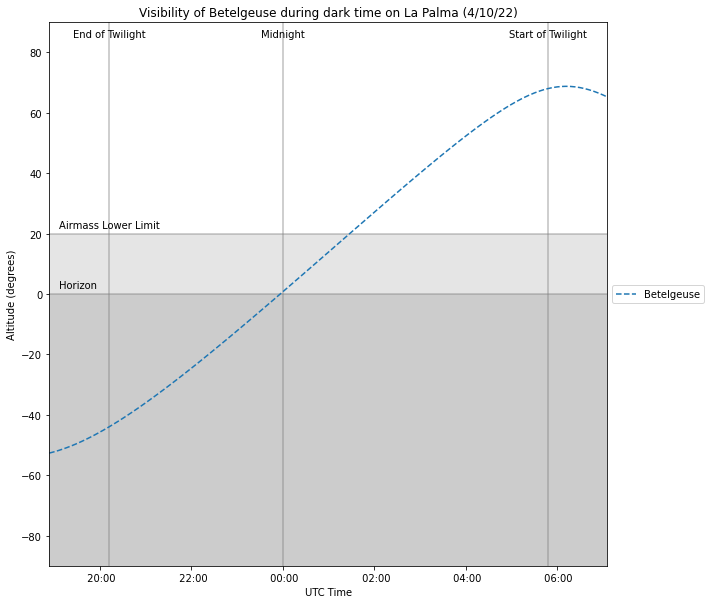

In [14]:
#then lets plot the changing altitude of Betelgeuse during darktime
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(times,altitudes,"--",label="Betelgeuse")

ax.plot(times,np.zeros(len(times)),color="grey",alpha=0.5,zorder=0) #horizon
ax.plot(times,20*np.ones(len(times)),color="grey",alpha=0.5,zorder=0) #lower alt limit

ax.vlines(darkstart.utc_datetime(), -90,90,color="grey",alpha=0.5,zorder=0)
ax.vlines(darkend.utc_datetime(), -90,90,color="grey",alpha=0.5,zorder=0)
ax.vlines(dt.datetime(2022, 10, 5, 0,0,0,tzinfo=utc), -90,90,color="grey",alpha=0.5,zorder=0)

#annotations
ax.annotate("End of Twilight", (darkstart.utc_datetime(),85),ha='center')
ax.annotate("Start of Twilight", (darkend.utc_datetime(),85),ha='center')
ax.annotate("Midnight", (dt.datetime(2022, 10, 5, 0,0,0,tzinfo=utc),85),ha='center')
ax.annotate("Horizon", (sunset.utc_datetime(),2),(10,0),textcoords="offset pixels")
ax.annotate("Airmass Lower Limit", (sunset.utc_datetime(),22),(10,0),textcoords="offset pixels")

#backgrounds
ax.axhspan(20, 0, facecolor='grey', alpha=0.2)
ax.axhspan(0, -90, facecolor='grey', alpha=0.4)

#formatting the plot
xfmt = mdates.DateFormatter(' %H:%M')
ax.xaxis.set_major_formatter(xfmt)
ax.set_xlabel("UTC Time")
ax.set_ylabel("Altitude (degrees)")
ax.set_xlim([times[0],times[-1]])
ax.set_ylim(-90,90)
ax.set_title("Visibility of Betelgeuse during dark time on La Palma (4/10/22)")

#display
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()